In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from models import CNN
from sklearn import preprocessing

In [2]:
# The data, split between train and test sets:
(_, _), (X, y) = cifar10.load_data()
print(np.min(X), np.max(X))
X = X.astype(np.float32)

0 255


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline

In [4]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto')
clf.fit(np.reshape(X_train, (X_train.shape[0], -1)), y_train.squeeze())

/home/thalles/anaconda3/envs/tf2_cpu/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [5]:
print("Train score:", clf.score(np.reshape(X_train,(X_train.shape[0], -1)), y_train),
      "Test score:", clf.score(np.reshape(X_test,(X_test.shape[0], -1)), y_test))

Train score: 0.4815 Test score: 0.388


## Self-Supervised pre-training

In [16]:
encoder = CNN(X.shape[1:])

_ = encoder(np.random.rand(1,32,32,3).astype(np.float32), head='f')
encoder.load_weights('encoder.h5')

In [17]:
X_train_repr, _ = encoder(tf.cast(X_train, tf.float32) / 255, head=tf.constant('f'), training=tf.constant(True))
X_test_repr, _ = encoder(tf.cast(X_test, tf.float32) / 255, head=tf.constant('f'), training=tf.constant(True))
print(X_train_repr.shape)
print(X_test_repr.shape)

(8000, 128)
(2000, 128)


In [18]:
scaler = preprocessing.StandardScaler().fit(X_train_repr)
X_train_repr = scaler.transform(X_train_repr)
X_test_repr = scaler.transform(X_test_repr)

In [19]:
clf = LogisticRegression(random_state=0, max_iter=400, solver='lbfgs', multi_class='auto')
clf.fit(X_train_repr, y_train.squeeze())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
print("Train score:", clf.score(X_train_repr, y_train.squeeze()), 
      "Test score:", clf.score(X_test_repr, y_test.squeeze()))
# 0.48 0.4665
# 0.535625 0.4845

Train score: 0.535625 Test score: 0.4845


In [27]:
X_train_repr[0]

array([-0.37765293, -0.92383405, -0.39135401, -1.90587745, -0.76886962,
       -1.06943286, -1.90403927,  1.54002992,  0.5396932 , -1.89237322,
        0.42027098,  0.14679922,  1.10647133,  0.22912532,  0.42709396,
       -1.06653007,  0.91075103,  1.53576994,  0.67946346,  0.17315402,
        0.01829583, -1.5869501 ,  1.06517901, -0.64780397,  1.07280761,
        0.34147313,  0.48160639, -1.63410068,  0.89358239,  0.83097523,
       -0.53191131,  0.81667875,  1.3841633 ,  0.58478835,  0.32239908,
       -0.70002947, -1.02977837,  0.56867551,  0.24990124,  0.00491053,
        1.13006976, -0.12291443,  0.15300392,  1.27191148, -1.80499874,
        0.36670888,  0.86174949, -1.67797498, -0.10358804,  0.53962909,
        1.20510989,  0.86933059, -0.1888454 , -0.10308279,  0.40721795,
        0.16172992, -1.25090833, -1.49952047,  1.36467481,  1.00254179,
        3.05896151, -1.33697104, -1.51215692,  1.56566767,  0.76382132,
       -0.53556993,  1.1519878 , -0.3383312 ,  1.48576834, -0.14

In [28]:
X_test_repr[0]

array([ 0.54960487,  0.67142471,  0.75946356, -0.66662573, -0.62567317,
        0.06094651, -0.37754752,  1.05923749, -1.0497831 , -0.74649929,
       -1.23877766,  1.08253991, -0.73533258,  0.35930499, -1.58648417,
       -0.79346567, -0.8481571 , -1.34944483,  0.61128455, -0.98195157,
        0.64961822,  0.24504072,  0.57136437, -0.32020988,  0.70904721,
       -0.49679625, -0.75269952, -0.87528692, -0.52843575, -1.24959443,
       -1.61731338, -0.52522851, -0.72850269, -1.04403133, -0.72582524,
       -2.220887  ,  0.8189236 ,  0.0620662 , -0.19464831, -0.44123941,
       -0.27732619, -0.91661297,  0.76273006, -0.10098966, -0.29651671,
        1.14429407,  0.79631883, -0.65430836,  1.33480394,  0.73976173,
        0.15260173,  1.15185808,  0.5616953 , -0.87306262,  1.57672168,
        0.7067896 , -0.09371897,  1.32885775,  0.20848414,  0.59275354,
       -0.66161159, -0.45653788,  0.380195  , -0.97456859, -0.71608543,
        1.0924213 ,  0.36174243,  0.2515606 , -0.52120185, -0.23

In [13]:
cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
loss = cosine_loss([[0.0001, 1], [1., 1]], [[0.0002, 1], [0., 1]])

print('Loss: ', loss.numpy())  # Loss: 0.5

Loss:  -0.8535534


In [14]:
a = tf.convert_to_tensor([1,6,5], dtype=tf.int32)
b = tf.convert_to_tensor([4,3,2], dtype=tf.int32)
res = tf.sets.intersection(a[None,:],b[None,:])
print(tf.size(res))

tf.Tensor(0, shape=(), dtype=int32)


In [15]:
a = np.array([28.171087, 30.802778], dtype=np.float32)
b = np.array([2.2323670e-06, 2.1488113e-06], dtype=np.float32)

print(a / (a+b))

[0.99999994 0.99999994]


In [16]:
samples = tf.random.categorical(tf.math.log([[0.5, 0.5]]), 5)
samples

<tf.Tensor: id=1539, shape=(1, 5), dtype=int64, numpy=array([[0, 1, 1, 0, 1]])>

In [17]:
shape = (10,8)

positive_indices = tf.constant([[1], [4]])
positive_indices_mask = tf.zeros_like(positive_indices.shape)

mask = tf.ones([shape[0]], dtype=tf.int32)
mask = tf.tensor_scatter_nd_update(mask, positive_indices, positive_indices_mask)
print(mask)

tf.Tensor([1 0 1 1 0 1 1 1 1 1], shape=(10,), dtype=int32)


In [18]:
p = tf.ones(shape[0])
p = p * tf.cast(mask, tf.float32)
p = p / tf.reduce_sum(p)
print(p)

candidate_negative_indices = tf.random.categorical(tf.math.log(tf.reshape(p, (1,-1))), 5000) # note log-prob
print(candidate_negative_indices)

tf.Tensor([0.125 0.    0.125 0.125 0.    0.125 0.125 0.125 0.125 0.125], shape=(10,), dtype=float32)
tf.Tensor([[8 0 9 ... 3 9 0]], shape=(1, 5000), dtype=int64)


(array([613.,   0., 558., 636.,   0., 643., 601., 650., 636., 663.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

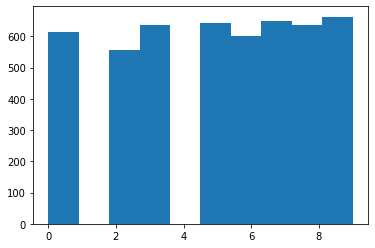

In [19]:
plt.hist(candidate_negative_indices)

In [20]:
# positive_indices = tf.constant([1,2], dtype=tf.int32)
# a = 

indices = tf.constant([[4], [3], [1], [7]])
updates = tf.constant([0, 0, 0, 0])

tensor = tf.ones([8], dtype=tf.int32)
mask = tf.tensor_scatter_nd_update(tensor, indices, updates)
print(updated)

NameError: name 'updated' is not defined

In [ ]:
indices = tf.constant([[4], [3], [1], [7]])
updates = tf.constant([9, 10, 11, 12])
tensor = tf.ones([12], dtype=tf.int32)
updated = tf.tensor_scatter_nd_add(tensor, indices, updates)
print(updated)

In [ ]:
import tensorflow as tf

In [ ]:
BS=2
N_NEG=3
N_DIM=4

In [ ]:
vi = tf.ones((BS, N_DIM))

a = tf.ones([BS,N_NEG,N_DIM])
negatives = tf.random.uniform([BS,N_NEG,N_DIM])
negatives

In [ ]:
cosine_similarity = tf.keras.losses.CosineSimilarity(reduction=tf.losses.Reduction.NONE, axis=-1)

In [ ]:
negatives

In [ ]:
similatiry = []
for vi_prime in tf.transpose(negatives, (1,0,2)):
    vi_prime = tf.expand_dims(vi_prime, axis=1)
    
    negatives_ = tf.expand_dims(tf.reshape(negatives, (-1,N_DIM)), axis=0)
    
    print(vi_prime)
    print("---------------")
#     print(negatives_)
#     print("---------------")
    s = cosine_similarity(vi_prime, negatives_)
    similatiry.append(s)
    print(s)
    s = tf.reduce_sum(s, axis=1)
#     print(s)
    print("---------------")
    print("---------------")

#     break

In [ ]:
res = cosine_similarity(negatives, negatives)

In [ ]:
cosine_similarity([0.34904468, 0.73694515, 0.02537,    0.54320323], 
                  [0.4723971,  0.58122766, 0.878623,   0.18785727])

## MAPFN

In [ ]:
print(negatives.shape)

@tf.function
def func(vi_prime):
    vi_prime = tf.expand_dims(vi_prime, axis=1)
    similarity = cosine_similarity(vi_prime, negatives)
    return similarity


squares = tf.map_fn(func, tf.transpose(negatives, (1,0,2)), parallel_iterations=BS)

## UNPACK

In [ ]:
tf.unstack(tf.transpose(negatives, (1,0,2)))